Approach 1: Final Test Set Evaluation

Loads full SavedModels and evaluates on HELD-OUT test set.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, roc_curve, auc
)
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# ==================== PATHS ====================
MODELS_DIR = '../models/models_approach1'
RESULTS_DIR = '../results/results_approach1'
SAVED_MODELS_DIR = os.path.join(MODELS_DIR, 'saved_models')
TEST_RAW_DIR = '../data/split_processed/test'  # Where raw .npy files are organized by category
INVENTORY_PATH = os.path.join(RESULTS_DIR, 'full_model_inventory.csv')
YAMNET_URL = 'https://tfhub.dev/google/yamnet/1'

os.makedirs(RESULTS_DIR, exist_ok=True)

In [2]:
# ==================== YAMNET EMBEDDING CLASS ====================
# (Required for loading models that use it)
@tf.keras.utils.register_keras_serializable()
class YamnetEmbedding(tf.keras.layers.Layer):
    def __init__(self, yamnet_model, **kwargs):
        super().__init__(**kwargs)
        self.yamnet_model = yamnet_model

    def call(self, inputs):
        # inputs shape: (batch, 15360)
        def map_fn(wave):
            scores, embeddings, _ = self.yamnet_model(wave)
            return tf.reduce_mean(embeddings, axis=0)
        return tf.map_fn(map_fn, inputs, dtype=tf.float32)

In [3]:
# ==================== LOAD TEST DATA ====================
# Load raw .npy files from category folders
print("Loading raw .npy files from category folders...")

# Map folder names to class names (adjusted to match your classes)
category_mapping = {
    'alarm_clock': 'Alarm_Clock',
    'car_horn': 'Car_Horn',
    'glass_breaking': 'Glass_Breaking',
    'gunshot': 'Gunshot',
    'siren': 'Siren'
}

raw_audio_list = []
labels_list = []
target_length = 15360  # 0.96s @ 16kHz

for folder_name, class_name in category_mapping.items():
    folder_path = os.path.join(TEST_RAW_DIR, folder_name)
    
    if not os.path.exists(folder_path):
        print(f"  Warning: Folder not found: {folder_path}")
        continue
    
    npy_files = sorted(glob(os.path.join(folder_path, '*.npy')))
    print(f"  Loading {len(npy_files)} files from {folder_name}...")
    
    for npy_file in npy_files:
        try:
            audio = np.load(npy_file)
            
            # Ensure 1D
            if audio.ndim > 1:
                audio = audio.flatten()
            
            # Check length
            if len(audio) != target_length:
                print(f"    Skipping {os.path.basename(npy_file)}: wrong length {len(audio)}")
                continue
            
            raw_audio_list.append(audio)
            labels_list.append(class_name)
            
        except Exception as e:
            print(f"    Error loading {os.path.basename(npy_file)}: {e}")

X_test_raw = np.array(raw_audio_list, dtype=np.float32)
y_test = np.array(labels_list)

print(f"\nTotal samples loaded: {len(X_test_raw):,}")
print(f"Audio shape: {X_test_raw.shape}")

Loading raw .npy files from category folders...
  Loading 246 files from alarm_clock...
  Loading 292 files from car_horn...
  Loading 144 files from glass_breaking...
  Loading 310 files from gunshot...
  Loading 312 files from siren...

Total samples loaded: 1,304
Audio shape: (1304, 15360)


In [4]:
# ==================== LOAD LABEL ENCODER ====================
label_encoder = joblib.load(os.path.join(MODELS_DIR, 'label_encoder.pkl'))
classes = label_encoder.classes_
print(f"\nClasses ({len(classes)}): {', '.join(classes)}")

# Encode labels
y_test_encoded = label_encoder.transform(y_test)

# Display class distribution
print(f"\n{'Category':<20} {'Count':<10} {'Percentage':<10}")
print("-"*50)
for idx, cls in enumerate(classes):
    count = np.sum(y_test_encoded == idx)
    percentage = count / len(y_test_encoded) * 100
    print(f"{cls:<20} {count:<10} {percentage:>6.2f}%")
print("-"*50)


Classes (5): Alarm_Clock, Car_Horn, Glass_Breaking, Gunshot, Siren

Category             Count      Percentage
--------------------------------------------------
Alarm_Clock          246         18.87%
Car_Horn             292         22.39%
Glass_Breaking       144         11.04%
Gunshot              310         23.77%
Siren                312         23.93%
--------------------------------------------------


In [5]:
# ==================== LOAD FULL MODELS ====================
print("\nLOADING SAVED MODELS")

inventory_df = pd.read_csv(INVENTORY_PATH)
model_paths = {}

for _, row in inventory_df.iterrows():
    model_name = row['Model']
    path = row['Path']
    if os.path.exists(path):
        model_paths[model_name] = path
        print(f"  Found: {model_name}")
    else:
        print(f"  Missing: {model_name} at {path}")

print(f"\nTotal models found: {len(model_paths)}")


LOADING SAVED MODELS
  Found: Random_Forest
  Found: XGBoost
  Found: Logistic_Regression
  Found: MLP
  Found: SVM

Total models found: 5


In [6]:
# ==================== INFERENCE FUNCTION ====================
def run_inference(model, audio_batch):
    """Run inference on batch of 0.96s audio clips"""
    start = time.time()
    probs = model.predict(audio_batch, verbose=0)
    latency_ms = (time.time() - start) * 1000 / len(audio_batch)
    return probs, latency_ms

# ==================== EVALUATE ALL MODELS ====================
print("\nRUNNING INFERENCE ON TEST SET")

results = []
all_predictions = {}
all_probabilities = {}

for model_name, model_path in model_paths.items():
    print(f"\nEvaluating: {model_name}")
    
    # Load model
    try:
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={'YamnetEmbedding': YamnetEmbedding}
        )
        print(f"  Model loaded successfully")
    except Exception as e:
        print(f"  Failed to load: {e}")
        continue
    
    # Run inference
    probs, latency_ms = run_inference(model, X_test_raw)
    y_pred = np.argmax(probs, axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    
    # Calculate metrics
    acc = accuracy_score(y_test_encoded, y_pred)
    f1_macro = f1_score(y_test_encoded, y_pred, average='macro')
    f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='macro')
    recall = recall_score(y_test_encoded, y_pred, average='macro')
    
    # Get model size
    size_mb = inventory_df[inventory_df['Model'] == model_name]['Size_MB'].values[0]
    
    results.append({
        'Model': model_name,
        'Accuracy': round(acc, 4),
        'F1_Macro': round(f1_macro, 4),
        'F1_Weighted': round(f1_weighted, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'Latency_ms_per_sample': round(latency_ms, 2),
        'Size_MB': size_mb
    })
    
    all_predictions[model_name] = y_pred_labels
    all_probabilities[model_name] = probs
    
    print(f"  Accuracy: {acc:.4f} | F1-Macro: {f1_macro:.4f} | Latency: {latency_ms:.2f} ms/sample")




RUNNING INFERENCE ON TEST SET

Evaluating: Random_Forest



  Model loaded successfully
  Accuracy: 0.8520 | F1-Macro: 0.8464 | Latency: 7.98 ms/sample

Evaluating: XGBoost
  Model loaded successfully
  Accuracy: 0.8612 | F1-Macro: 0.8574 | Latency: 7.59 ms/sample

Evaluating: Logistic_Regression
  Model loaded successfully
  Accuracy: 0.8712 | F1-Macro: 0.8681 | Latency: 7.47 ms/sample

Evaluating: MLP
  Model loaded successfully
  Accuracy: 0.8750 | F1-Macro: 0.8722 | Latency: 8.40 ms/sample

Evaluating: SVM
  Model loaded successfully
  Accuracy: 0.8650 | F1-Macro: 0.8623 | Latency: 7.73 ms/sample


In [7]:
# ==================== RESULTS SUMMARY ====================
print("TEST SET EVALUATION RESULTS")
print("="*80)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1_Macro', ascending=False)
print("\n" + results_df[['Model', 'F1_Macro', 'Accuracy', 'Latency_ms_per_sample', 'Size_MB']].to_string(index=False))

# Save leaderboard
leaderboard_path = os.path.join(RESULTS_DIR, 'final_test_leaderboard.csv')
results_df.to_csv(leaderboard_path, index=False)
print(f"\nLeaderboard saved: {leaderboard_path}")

TEST SET EVALUATION RESULTS

              Model  F1_Macro  Accuracy  Latency_ms_per_sample  Size_MB
                MLP    0.8722    0.8750                   8.40     25.4
Logistic_Regression    0.8681    0.8712                   7.47     18.1
                SVM    0.8623    0.8650                   7.73     25.4
            XGBoost    0.8574    0.8612                   7.59     25.4
      Random_Forest    0.8464    0.8520                   7.98     25.4

Leaderboard saved: ../results/results_approach1\final_test_leaderboard.csv



GENERATING CONFUSION MATRICES
Confusion matrices saved: ../results/results_approach1\final_test_confusion_matrices.png


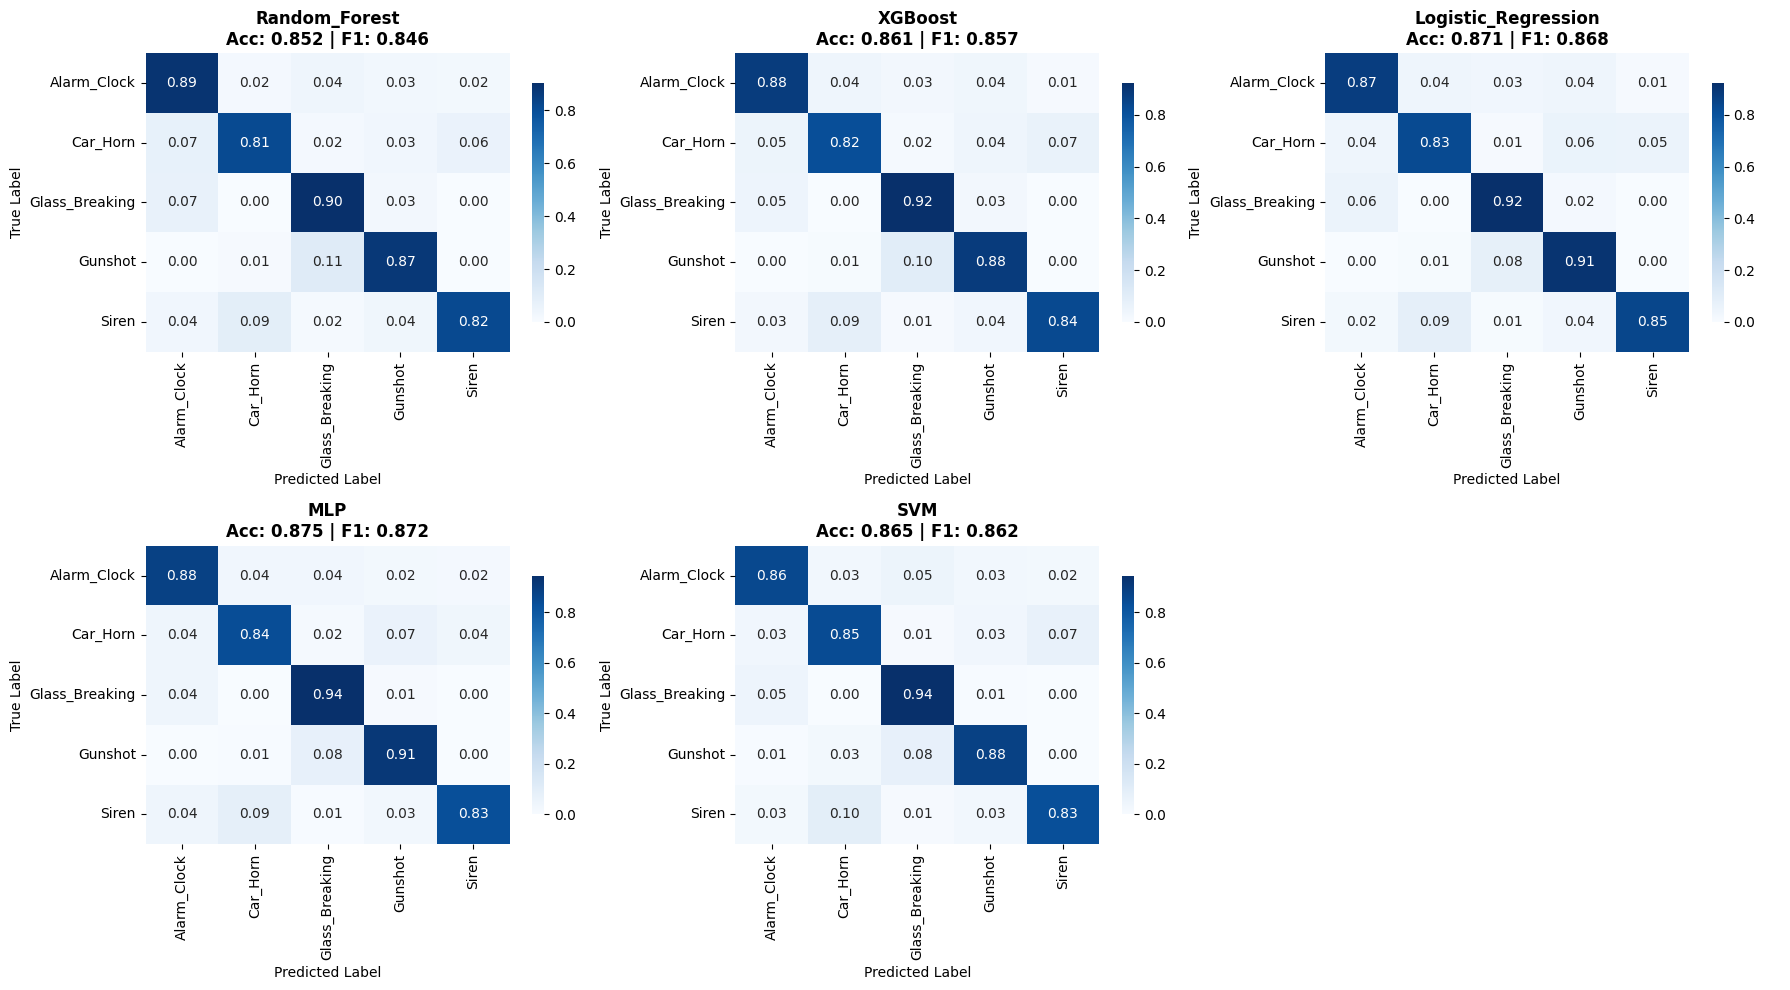

In [8]:
# ==================== CONFUSION MATRICES ====================
print("\nGENERATING CONFUSION MATRICES")
n_models = len(all_predictions)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (model_name, y_pred) in enumerate(all_predictions.items()):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                ax=axes[idx], cbar_kws={'shrink': 0.8})
    
    acc = results_df[results_df['Model'] == model_name]['Accuracy'].values[0]
    f1 = results_df[results_df['Model'] == model_name]['F1_Macro'].values[0]
    
    axes[idx].set_title(f'{model_name}\nAcc: {acc:.3f} | F1: {f1:.3f}', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

# Hide unused subplots
for j in range(len(all_predictions), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
cm_path = os.path.join(RESULTS_DIR, 'final_test_confusion_matrices.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrices saved: {cm_path}")
plt.show()


GENERATING ROC CURVES
ROC curves saved: ../results/results_approach1\final_test_roc_curves.png


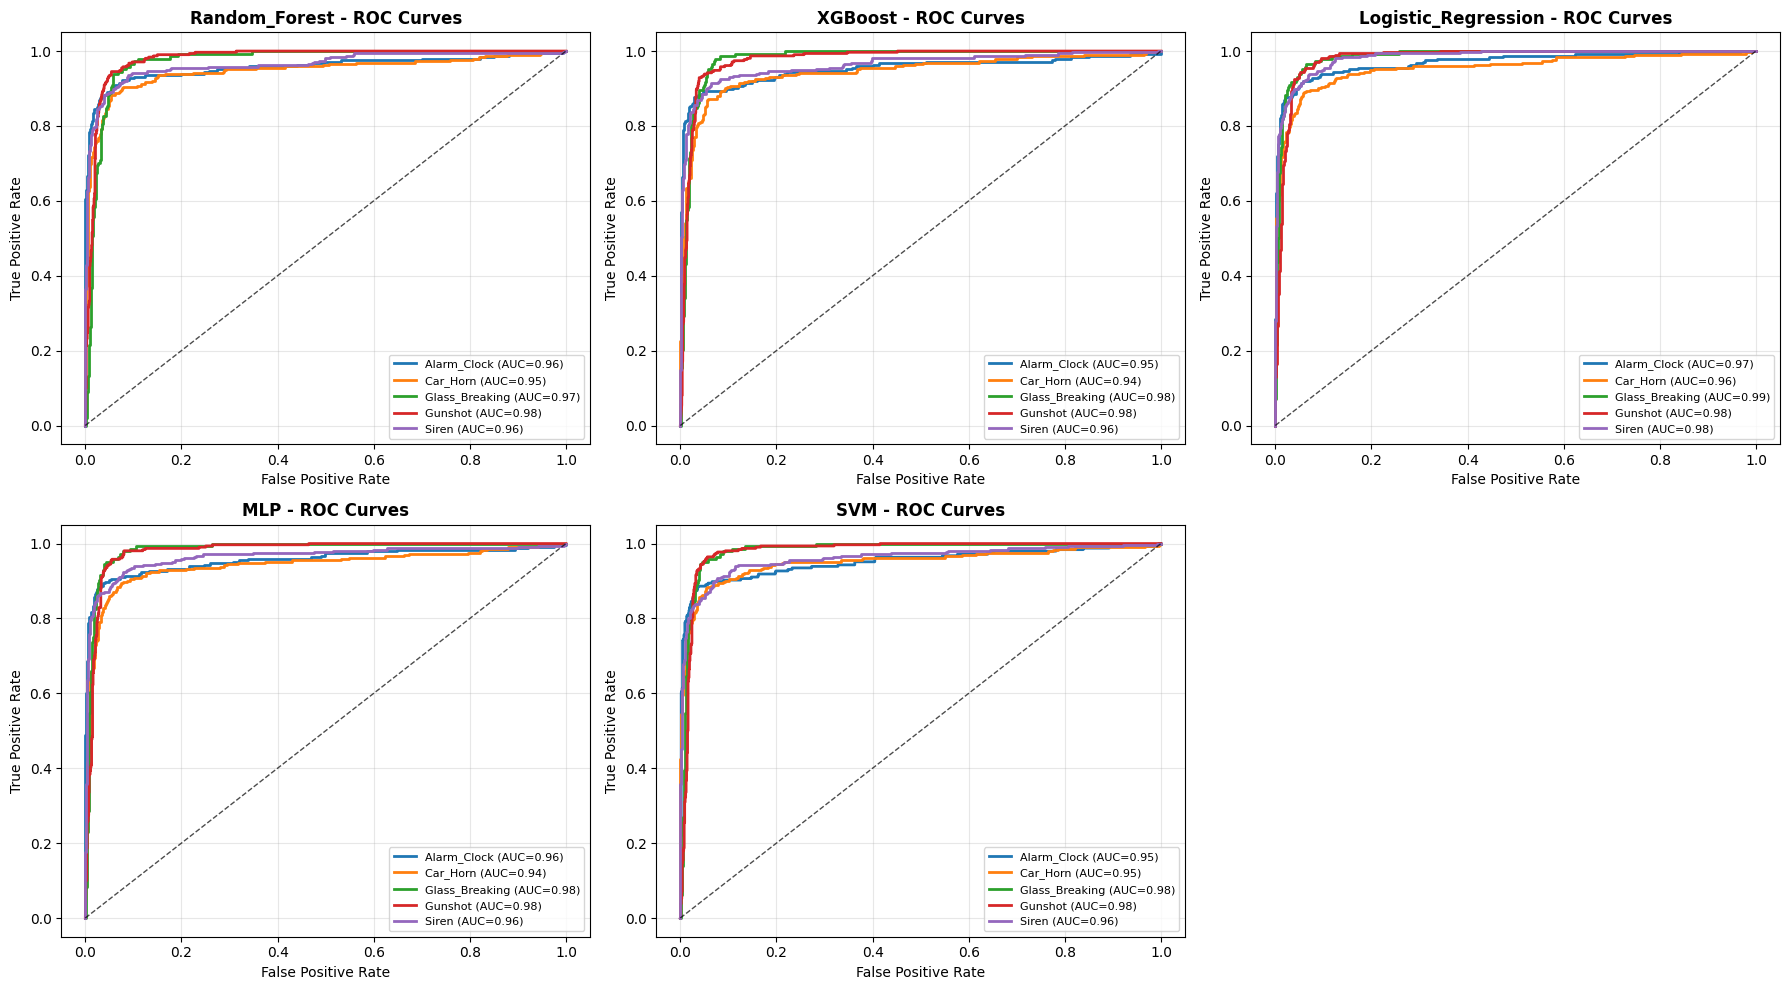

In [9]:
# ==================== ROC CURVES ====================
print("\nGENERATING ROC CURVES")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (model_name, probs) in enumerate(all_probabilities.items()):
    for i, class_name in enumerate(classes):
        y_binary = (y_test_encoded == i).astype(int)
        fpr, tpr, _ = roc_curve(y_binary, probs[:, i])
        roc_auc = auc(fpr, tpr)
        axes[idx].plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')
    
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.7)
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'{model_name} - ROC Curves', fontweight='bold')
    axes[idx].legend(fontsize=8, loc='lower right')
    axes[idx].grid(alpha=0.3)

# Hide unused subplots
for j in range(len(all_probabilities), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
roc_path = os.path.join(RESULTS_DIR, 'final_test_roc_curves.png')
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
print(f"ROC curves saved: {roc_path}")
plt.show()


GENERATING PER-CLASS F1 SCORES
Per-class F1 chart saved: ../results/results_approach1\final_per_class_f1.png


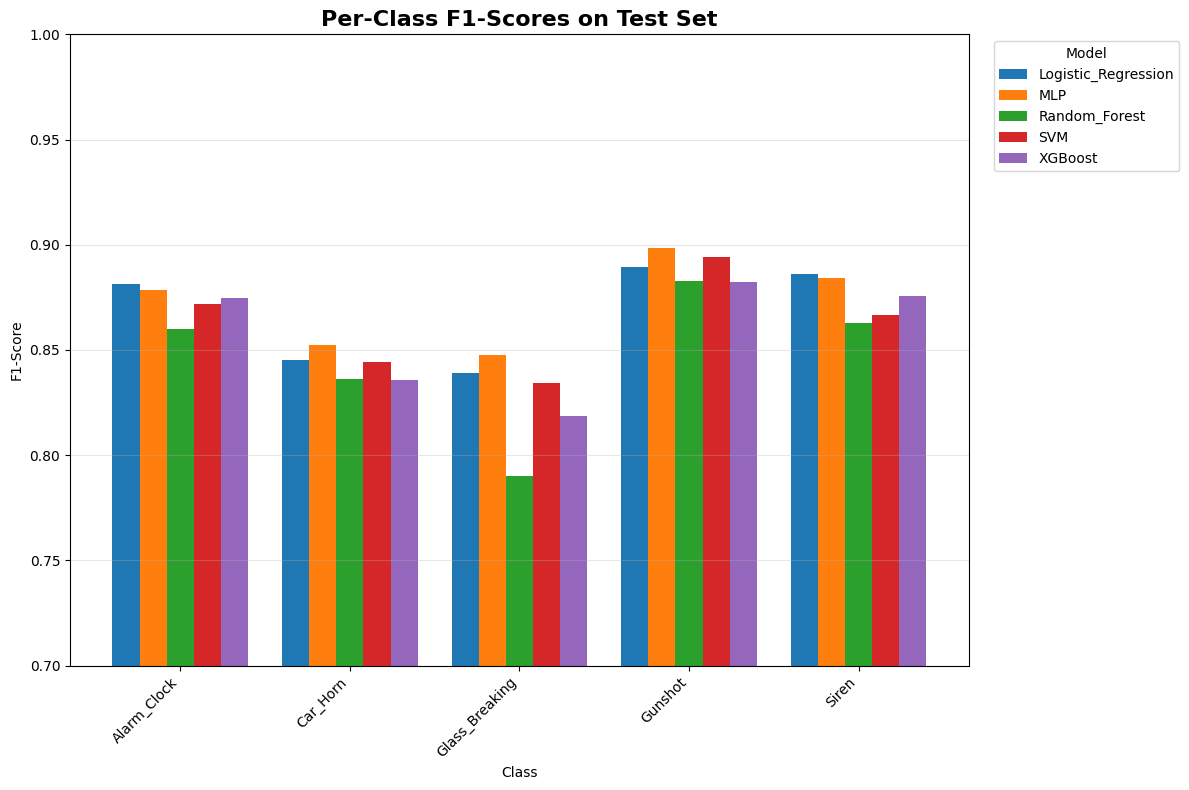

Per-class metrics saved: ../results/results_approach1\final_per_class_metrics.csv


In [10]:
# ==================== PER-CLASS F1 SCORES ====================
print("\nGENERATING PER-CLASS F1 SCORES")

per_class_data = []
for model_name, y_pred in all_predictions.items():
    report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
    for cls in classes:
        per_class_data.append({
            'Model': model_name,
            'Class': cls,
            'F1': report[cls]['f1-score'],
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'Support': int(report[cls]['support'])
        })

per_class_df = pd.DataFrame(per_class_data)
pivot_f1 = per_class_df.pivot(index='Class', columns='Model', values='F1')

plt.figure(figsize=(12, 8))
pivot_f1.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Per-Class F1-Scores on Test Set', fontsize=16, fontweight='bold')
plt.ylabel('F1-Score')
plt.xlabel('Class')
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

per_class_path = os.path.join(RESULTS_DIR, 'final_per_class_f1.png')
plt.savefig(per_class_path, dpi=300, bbox_inches='tight')
print(f"Per-class F1 chart saved: {per_class_path}")
plt.show()

# Save per-class details
per_class_csv = os.path.join(RESULTS_DIR, 'final_per_class_metrics.csv')
per_class_df.to_csv(per_class_csv, index=False)
print(f"Per-class metrics saved: {per_class_csv}")


GENERATING PERFORMANCE vs SIZE & LATENCY
Tradeoff analysis saved: ../results/results_approach1\final_tradeoff_analysis.png


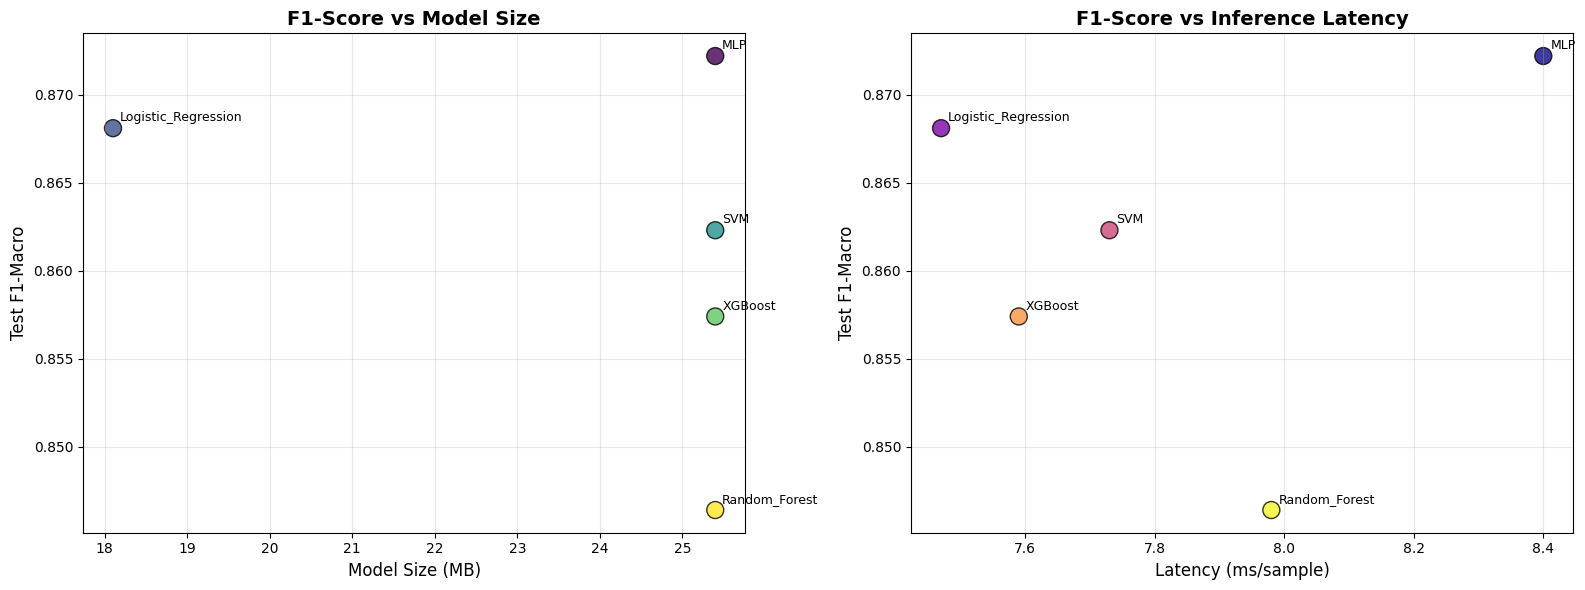

In [11]:
# ==================== PERFORMANCE TRADEOFFS ====================
print("\nGENERATING PERFORMANCE vs SIZE & LATENCY")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# F1 vs Size
sizes = results_df['Size_MB']
f1s = results_df['F1_Macro']
models = results_df['Model']

ax1.scatter(sizes, f1s, s=150, c=range(len(models)), cmap='viridis', alpha=0.8, edgecolors='black')
for i, model in enumerate(models):
    ax1.annotate(model, (sizes.iloc[i], f1s.iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax1.set_xlabel('Model Size (MB)', fontsize=12)
ax1.set_ylabel('Test F1-Macro', fontsize=12)
ax1.set_title('F1-Score vs Model Size', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# F1 vs Latency
latency = results_df['Latency_ms_per_sample']
ax2.scatter(latency, f1s, s=150, c=range(len(models)), cmap='plasma', alpha=0.8, edgecolors='black')
for i, model in enumerate(models):
    ax2.annotate(model, (latency.iloc[i], f1s.iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Latency (ms/sample)', fontsize=12)
ax2.set_ylabel('Test F1-Macro', fontsize=12)
ax2.set_title('F1-Score vs Inference Latency', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
tradeoff_path = os.path.join(RESULTS_DIR, 'final_tradeoff_analysis.png')
plt.savefig(tradeoff_path, dpi=300, bbox_inches='tight')
print(f"Tradeoff analysis saved: {tradeoff_path}")
plt.show()

In [12]:
# ==================== FINAL REPORT ====================

best_model = results_df.iloc[0]
print(f"\nBEST MODEL: {best_model['Model']}")
print(f"  Test F1-Macro:  {best_model['F1_Macro']:.4f}")
print(f"  Test Accuracy:  {best_model['Accuracy']:.4f}")
print(f"  Precision:      {best_model['Precision']:.4f}")
print(f"  Recall:         {best_model['Recall']:.4f}")
print(f"  Latency:        {best_model['Latency_ms_per_sample']:.2f} ms/sample")
print(f"  Model Size:     {best_model['Size_MB']}")



BEST MODEL: MLP
  Test F1-Macro:  0.8722
  Test Accuracy:  0.8750
  Precision:      0.8671
  Recall:         0.8824
  Latency:        8.40 ms/sample
  Model Size:     25.4
